# **<center>New York City Motor Vehicle Collisions Analysis Report</center>**

## <center>Analyst: Noah Otieno Oyugi </center>


## **Executive Summary**

**Objective**

The primary objective of this analysis was to examine motor vehicle collisions data for New York City in the  years 2022 and 2023, with a focus on identifying trends, patterns and contributing factors to these incidents. 

**Key Findings**

 - The total number of collisions declined by **4%** by the end of 2023 compared to 2022.
 - The total number of fatalities declined by **2%** by the end of 2023 compared to 2022.
 - The overall number of injured road users increased by **2%** by the end of 2023 compared to 2022.
 - Intersections led with **48%** of total collisions, contributing to **58%** of fatalities.
 - Brooklyn led in total number of collisions with **35%** of total collisions contributing to **32%** of total fatalities. 
 - Drivers inattention contributed to **33%** of total number of vehicles involved in collisions.

**Data Tools Used:**

Pandas, Seaborn, Matplotlib, and SQL

In [48]:
import warnings
import pandas as pd
import seaborn as sns
import sqlite3 as sqlite
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# Suppress warnings
warnings.simplefilter(action='ignore')

# Connect to the SQLite database
connection = sqlite.connect('motor_vehicle_collisions.db')

# Set seaborn theme and customizations
sns.set_theme(context='paper', style='white', palette='deep')
plt.rcParams.update({
    'lines.linewidth': 1.5,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'font.family': 'Times New Roman',
    'font.size': 14,
    'figure.dpi': 100,
    'figure.figsize': (10, 5)
})
pd.options.display.float_format = "{:,.2f}".format


## **Collisions Analysis**

In [49]:
total_collisions_query = """
    SELECT
        *
    FROM
        collisions
"""
total_collisions = (pd.read_sql_query(total_collisions_query, connection)
                    .assign(date = lambda x: pd.to_datetime(x.date))
                    .set_index('date')
                    )
total_collisions.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 200467 entries, 2022-01-01 01:30:00 to 2023-12-31 17:55:00
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time               200467 non-null  object 
 1   collision_id       200467 non-null  int64  
 2   Town               134498 non-null  object 
 3   latitude           184238 non-null  float64
 4   longitude          184238 non-null  float64
 5   zip_code           134474 non-null  object 
 6   on_street_name     145419 non-null  object 
 7   off_street_name    55045 non-null   object 
 8   cross_street_name  95605 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 15.3+ MB


### **Hourly Collisions Analysis**

In [50]:
# Get the hourly summary of collisions
hourly_collisions_summary = (pd
                             .DataFrame(total_collisions
                                        .resample('H')['collision_id']
                                        .nunique()
                                        )
                             .rename(columns = {'date': 'hour'})
                             )
#add the hour column
hourly_collisions_summary = (hourly_collisions_summary
                             .assign(hour = lambda x: x.index.hour)
                             .rename(columns={'collision_id':'collisions'})
                             )
hourly_collisions_summary.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2022-01-01 00:00:00 to 2023-12-31 23:00:00
Freq: h
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   collisions  17520 non-null  int64
 1   hour        17520 non-null  int32
dtypes: int32(1), int64(1)
memory usage: 342.2 KB


In [51]:
#get the summary statistics of hourly collisions
(hourly_collisions_summary[['collisions']]
 .describe().T
 .drop(columns='count')
 .astype(int)
 )


,mean,std,min,25%,50%,75%,max
collisions,11,5,0,7,11,15,45


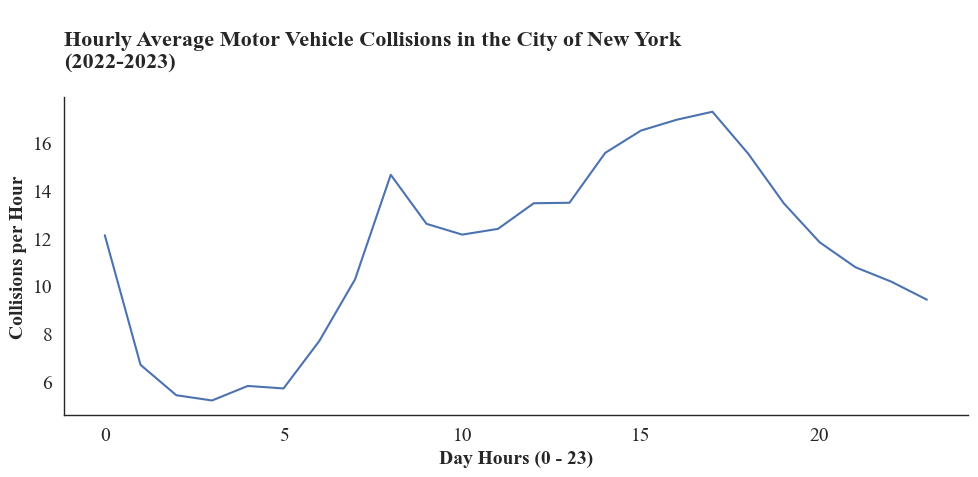

In [52]:
## Plotting the mean-hourly collisions across the hours of day 
grpd_hourly_summary = (hourly_collisions_summary
                       .groupby('hour')['collisions'].mean())
ax = grpd_hourly_summary.plot(legend=False)
ax.set_title('\nHourly Average Motor Vehicle Collisions in the City of New York\n(2022-2023)\n', 
             fontweight='bold', loc='left')
ax.set_xlabel('Day Hours (0 - 23)', 
              fontweight='bold')
ax.set_ylabel('Collisions per Hour', 
              fontweight='bold')
plt.tight_layout();


>#### **Hourly Collisions**

On average, there were **11 collisions per hour** in New York City. Here's how the collision rates varied throughout the day:

1. **Morning Hours (approximately 5:00 AM to 9:00 AM):**

- During this period, the city experienced an average of **6 collisions per hour**. 

2. **Mid-Morning to 17:00 Hours (approximately 10:00 AM to 5:00 PM):**

- Between mid-morning and 5:00 PM, the collision rate remained fairly consistent, averaging around **12 to 16 collisions per hour**. 
- This period likely corresponds to peak traffic hours when congestion and activity on the roads are higher.

### **Daily Collisions Analysis**

In [53]:
# get the total number of daily collisions
daily_collisions = (pd.DataFrame(total_collisions
                                 .groupby(total_collisions.index.date,as_index=False)
                                 .size()
                                 )
                    .rename(columns = {'size': 'Total',
                                       'index':'date'})
                    .assign(date = lambda x: pd.to_datetime(x.date))
                    )
daily_collisions.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    730 non-null    datetime64[ns]
 1   Total   730 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.5 KB


In [54]:
# summary statistics for daily collisions
(daily_collisions[['Total']]
 .describe().T
 .drop(columns = 'count')
 .astype(int)
 )


,mean,std,min,25%,50%,75%,max
Total,274,34,155,252,276,297,373


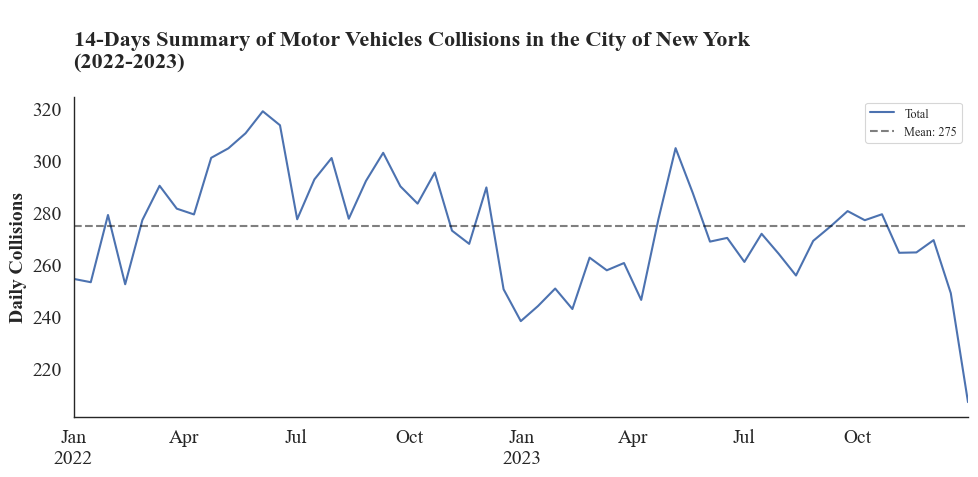

In [55]:
# plotting the 14-day average collisions
ax = (daily_collisions
      .set_index('date')
      .Total.resample('14D')
      .mean()
      .plot()
      )
ax.axhline(y = daily_collisions.Total.mean(), color = 'black', 
           linestyle='--', linewidth = 1.5, alpha = 0.5, 
           label = f'Mean: {daily_collisions.Total.mean():,.0f}'
           )
ax.set_title('\n14-Days Summary of Motor Vehicles Collisions in the City of New York\n(2022-2023)\n', 
             fontweight='bold', loc='left')
ax.set_ylabel('Daily Collisions', fontweight='bold')
ax.set_xlabel('')
ax.legend()
plt.tight_layout();


>#### **Daily Collisions**

In 2022, the average number of collisions per day was 275. During this period, most days between March and November recorded collision counts above this average.

However, in 2023, there was a shift. Many days saw collision values fall below the daily average.

This trend suggests that collision patterns changed over the two years, potentially influenced by various factors. Further analysis could reveal insights into these fluctuations and help inform decision-making processes related to road safety.



### **Monthly Collisions Analysis**

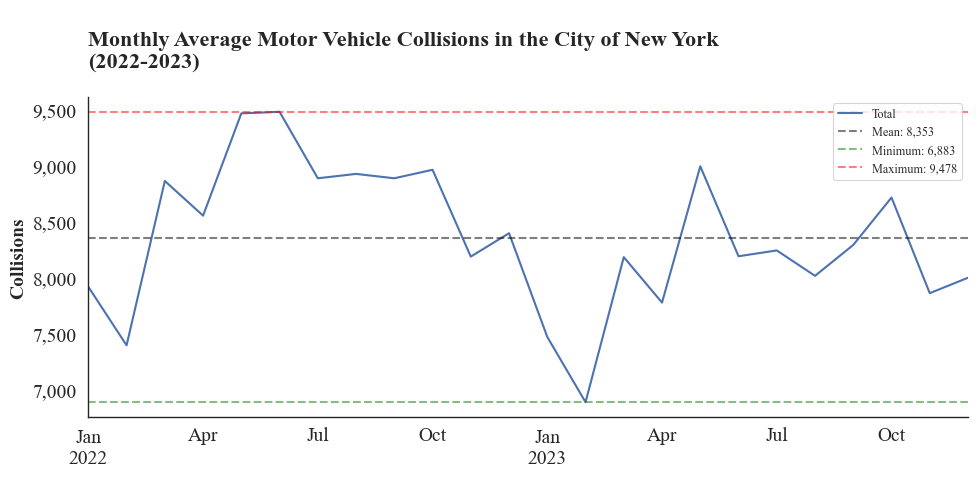

In [56]:
monthly_collisions = (daily_collisions
                      .set_index('date')
                      .resample('M').sum()
                      .reset_index()
                      .rename(columns={'total':'Total'})   
                      )
ax = monthly_collisions.plot(x='date', y='Total')
ax.axhline(y = monthly_collisions.Total.mean(), color = 'black', 
           linestyle='--', linewidth = 1.5, alpha = 0.5, 
           label = f'Mean: {monthly_collisions.Total.mean():,.0f}')
ax.axhline(y = monthly_collisions.Total.min(), color = 'green', 
           linestyle='--', linewidth = 1.5, alpha = 0.5, 
           label = f'Minimum: {monthly_collisions.Total.min():,.0f}')
ax.axhline(y = monthly_collisions.Total.max(), color = 'red', 
           linestyle='--', linewidth = 1.5, alpha = 0.5, 
           label = f'Maximum: {monthly_collisions.Total.max():,.0f}')
ax.set_title('\nMonthly Average Motor Vehicle Collisions in the City of New York\n(2022-2023)\n', 
             fontweight='bold', loc='left')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Collisions', fontweight='bold')
ax.set_xlabel('')
ax.legend()
plt.tight_layout();


>#### **Monthly Collisions**

In New York City, the average number of monthly collisions stands at **8,353**. Here's how the collision rates evolved over the two years:

- **May and June of 2022** witnessed the highest number of collisions. These months were particularly eventful in terms of road incidents.

- In contrast, **February 2023** recorded the lowest number of collisions. During this month, road safety seemed to improve significantly.

This trend highlights the seasonal variations in collision rates and underscores the importance of monitoring traffic safety measures year-round.


### **Collision by Seasons Analysis**

In [57]:
# write a function to get the seasons for each year
def get_season_with_year(date):
    month = date.month
    day = date.day

    if (month == 12 and day >= 21) or (month <= 2):
        season = 'Winter'
    elif 3 <= month <= 5:
        season = 'Spring'
    elif 6 <= month <= 8:
        season = 'Summer'
    else:
        season = 'Autumn'

    return f'{season}-{date.year}'

daily_collisions['season'] = daily_collisions['date'].apply(get_season_with_year)
daily_collisions


,date,Total,season
0,2022-01-01,283,Winter-2022
1,2022-01-02,180,Winter-2022
2,2022-01-03,208,Winter-2022
3,2022-01-04,255,Winter-2022
4,2022-01-05,306,Winter-2022
...,...,...,...
725,2023-12-27,234,Winter-2023
726,2023-12-28,273,Winter-2023
727,2023-12-29,263,Winter-2023
728,2023-12-30,228,Winter-2023


In [58]:
seasonal_collisions_summary = (daily_collisions
                               .groupby('season',as_index=False).Total.sum()
                               .sort_values(by='Total', ascending=False)
                               .assign(Total = lambda x: x.Total.astype(int))
                               )
seasonal_collisions_summary


,season,Total
0,Autumn-2022,31730
1,Autumn-2023,30284
4,Summer-2022,27285
2,Spring-2022,26874
3,Spring-2023,24943
5,Summer-2023,24438
6,Winter-2022,17996
7,Winter-2023,16917


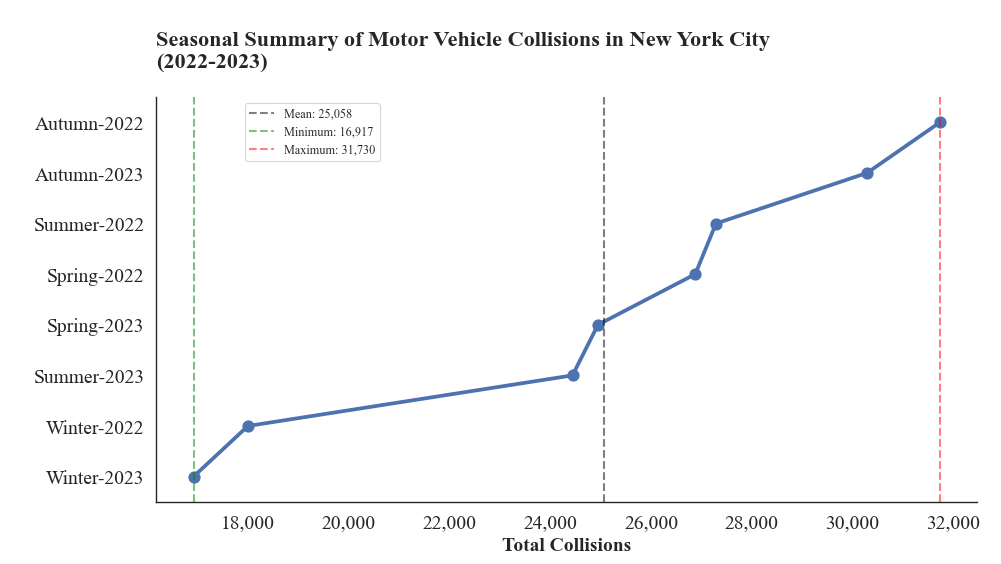

In [59]:
ax = (sns
      .catplot(data=seasonal_collisions_summary, x='Total', y='season', 
               kind='point', orient='h', height=5, aspect=2)
      .set_xlabels('Total Collisions', fontweight='bold')
      .set_ylabels(' ')
      )
for ax in ax.axes.flat:
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.set_title('\nSeasonal Summary of Motor Vehicle Collisions in New York City\n(2022-2023)\n',
                 fontweight='bold', loc='left')
    ax.axvline(x = seasonal_collisions_summary.Total.mean(), color = 'black', 
               linestyle='--', linewidth = 1.5, alpha = 0.5, 
               label = f'Mean: {seasonal_collisions_summary.Total.mean():,.0f}')
    ax.axvline(x = seasonal_collisions_summary.Total.min(), color = 'green', 
               linestyle='--', linewidth = 1.5, alpha = 0.5, 
               label = f'Minimum: {seasonal_collisions_summary.Total.min():,.0f}')
    ax.axvline(x = seasonal_collisions_summary.Total.max(), color = 'red', 
               linestyle='--', linewidth = 1.5, alpha = 0.5, 
               label = f'Maximum: {seasonal_collisions_summary.Total.max():,.0f}')
    plt.legend(bbox_to_anchor=(0.19, 1), loc='upper center', ncol=1)
    


>#### **Seasonal Collisions**

Across both years, the average seasonal collisions totaled **25,058** incidents per season. Here's how the data unfolded:

- **Winter**: During both years, the winter seasons experienced remarkably low collision rates. Perhaps the weather conditions played a role in reducing accidents during these colder months.

- **Autumn**: Interestingly, autumn emerged as the season with the highest collision incidents in both years. Falling leaves, changing road conditions, and increased traffic might contribute to this trend.

- **Summer** and **Spring**: These seasons generally saw above-average collision rates. However, in **Spring 2023**, there was a notable dip in incidents. Perhaps improved safety measures or other factors influenced this change.

Understanding these seasonal variations can inform targeted safety interventions and help reduce collisions year-round.


### **Annual Change**

In [60]:
annual_collisions = (daily_collisions
                      .set_index('date')
                      .resample('Y').Total.sum()
                      .reset_index()   
                      )
annual_collisions


,date,Total
0,2022-12-31,103885
1,2023-12-31,96582


In [61]:
annual_change_collision = (((annual_collisions.Total.iloc[-1] - \
                             annual_collisions.Total.iloc[0])\
                            / annual_collisions.Total.sum())*100)
annual_change_collision


-3.6429936099208344

>#### **Annual Change**

Between 2022 and 2023, the total number of collisions declined by **4%**. Specifically:

- In 2022, there were **103,885** collisions.
- In 2023, the number decreased to **96,582** collisions.

This reduction suggests positive trends in road safety efforts.

## **Fatalities Analysis**

In [62]:
road_user_deaths_query = """
    SELECT
        vc_tbl.date AS date,
        d_tbl.pedestrians AS pedestrians,
        d_tbl.cyclists AS cyclists,
        d_tbl.motorists AS motorists
    FROM
        deaths AS d_tbl JOIN collisions AS vc_tbl USING(collision_id)
"""
road_user_deaths = (pd.read_sql_query(road_user_deaths_query, connection)
                    .assign(date = lambda x: pd.to_datetime(x.date))
                    )
road_user_deaths.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200467 entries, 0 to 200466
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         200467 non-null  datetime64[ns]
 1   pedestrians  200467 non-null  int64         
 2   cyclists     200467 non-null  int64         
 3   motorists    200467 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.1 MB


### **Daily Fatalities Analysis**

In [63]:
daily_fatalities_summary = (road_user_deaths
                            .set_index('date')
                            .resample('D').sum()
                            .assign(total= lambda x: x.pedestrians + x.cyclists + x.motorists)
                            .reset_index()
                            )
daily_fatalities_summary.head()


,date,pedestrians,cyclists,motorists,total
0,2022-01-01,0,0,0,0
1,2022-01-02,1,0,1,2
2,2022-01-03,0,0,0,0
3,2022-01-04,1,0,1,2
4,2022-01-05,0,0,0,0


In [64]:
(daily_fatalities_summary[['pedestrians','motorists','cyclists','total']]
 .describe().T
 .drop(columns = 'count')
 .astype(int)
 )


,mean,std,min,25%,50%,75%,max
pedestrians,0,0,0,0,0,1,3
motorists,0,0,0,0,0,1,4
cyclists,0,0,0,0,0,0,1
total,0,0,0,0,0,1,5


>#### **Daily Fatalities**

- **Overall Trends**: On most days, there are no fatalities resulting from collisions. However, occasionally, a single road user loses their life due to a collision. In rare instances, the toll can be much higher, with up to 5 road users losing their lives in a single day.

- **Victim Profiles**:
    - **Motorists**: Motor vehicle occupants (such as drivers and passengers) are frequently affected by fatal collisions. Their vulnerability within the vehicle contributes to this trend.
    - **Pedestrians**: Pedestrians are also significantly impacted. Lack of protection and exposure to traffic make them vulnerable.
    - **Cyclists**: Interestingly, cyclists are less commonly involved in fatal collisions. Their use of dedicated lanes and protective gear may contribute to this lower incidence.

Understanding these patterns can guide safety measures and interventions to prevent fatalities on the roads.


### **Annual Fatalities Analysis**

In [65]:
annual_fatalities = (daily_fatalities_summary
                     .set_index('date')
                      .resample('Y').sum()
                      .reset_index()
                      )


In [66]:
annual_fatalities = (annual_fatalities
                     .assign(year = lambda x: x.date.dt.year)
                     .rename(columns = {'pedestrians':'Pedestrians',
                                        'cyclists':'Cyclists',
                                        'motorists':'Motorists',
                                        'total':'Total',
                                        'year':'Year'}
                             )
                     )
annual_fatalities


,date,Pedestrians,Cyclists,Motorists,Total,Year
0,2022-12-31,135,19,116,270,2022
1,2023-12-31,104,29,127,260,2023


In [67]:
annual_fatalities = (annual_fatalities
                     .melt(id_vars=['Year'],
                           value_vars=['Pedestrians', 'Cyclists', 'Motorists', 'Total'],
                           var_name='road_user_group',
                           value_name='value'
                           )
                     .pivot(index='road_user_group', columns='Year', values='value')
                     )


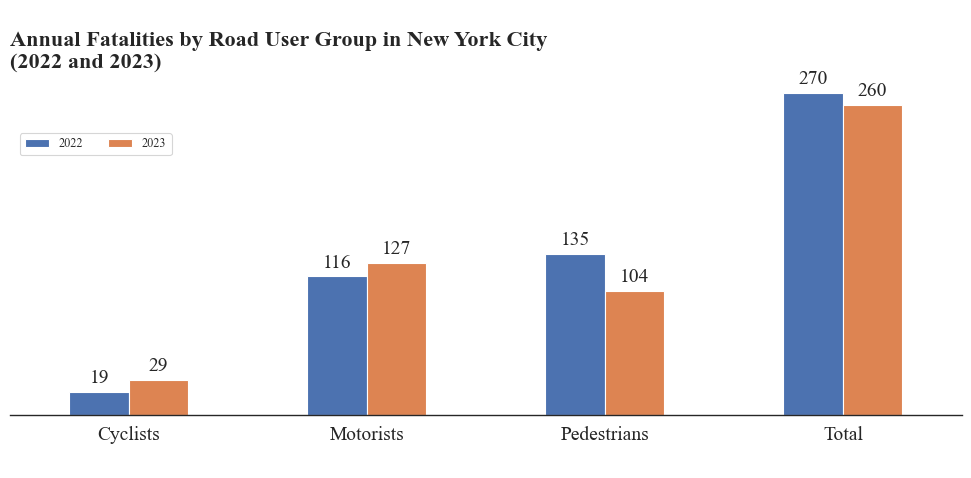

In [68]:
ax = annual_fatalities.plot(kind='bar')
ax.set_xticklabels(annual_fatalities.index, rotation=0, ha='center')
ax.set_xlabel(' ')
ax.set_title('\nAnnual Fatalities by Road User Group in New York City\n(2022 and 2023)', loc='left', fontweight='bold')
ax.spines['left'].set_visible(False)
ax.tick_params(left=False, labelleft=False)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
plt.legend(bbox_to_anchor=(0.09, 0.85),
           loc='upper center', ncol=2)
plt.tight_layout()
plt.show()


>#### **Annual Fatalities**

Between 2022 and 2023, the overall number of fatalities declined by **2%**. Here are the specifics:

- **Overall Trends**:
    - In 2022, there were **270** fatalities.
    - In 2023, the number decreased to **260** fatalities.

- **Cyclists**:
    - Cyclists experienced a significant increase in fatalities, rising by **21%**.
    - In 2022, there were **19** cyclist fatalities.
    - In 2023, this number increased to **29**.

- **Motorists**:
    - Motor vehicle occupants (motorists) also saw an increase in fatalities, albeit smaller.
    - In 2022, there were **116** motorist fatalities.
    - In 2023, this number rose to **127**.

- **Pedestrians**:
    - Pedestrians, on the other hand, experienced a decrease in fatalities.
    - In 2022, there were **135** pedestrian fatalities.
    - In 2023, this number decreased to **104**.

These trends highlight the need for continued safety measures and targeted interventions to protect all road users.

### **Seasonal Fatalities Analysis**

In [69]:
def get_season_with_year(date):
    month = date.month

    # Get the last two digits of the year
    short_year = date.year % 100

    if (month == 12 and date.day >= 21) or (month <= 2):
        season = 'Winter'
    elif 3 <= month <= 5:
        season = 'Spring'
    elif 6 <= month <= 8:
        season = 'Summer'
    else:
        season = 'Autumn'

    return f'{season}-{short_year}'

daily_fatalities_summary['season'] = daily_fatalities_summary['date'].apply(get_season_with_year)
daily_fatalities_summary


,date,pedestrians,cyclists,motorists,total,season
0,2022-01-01,0,0,0,0,Winter-22
1,2022-01-02,1,0,1,2,Winter-22
2,2022-01-03,0,0,0,0,Winter-22
3,2022-01-04,1,0,1,2,Winter-22
4,2022-01-05,0,0,0,0,Winter-22
...,...,...,...,...,...,...
725,2023-12-27,1,0,1,2,Winter-23
726,2023-12-28,1,1,0,2,Winter-23
727,2023-12-29,0,0,0,0,Winter-23
728,2023-12-30,0,1,0,1,Winter-23


In [70]:
## Pivoted Fatalities Summary ordered by the total number of fatalities
seasonal_fatalities_summary = (daily_fatalities_summary
                               .groupby('season',as_index=False)[['pedestrians','cyclists','motorists','total']].sum()
                               .sort_values(by='total', ascending=False)
                               )
seasonal_fatalities_summary


,season,pedestrians,cyclists,motorists,total
1,Autumn-23,37,5,41,83
0,Autumn-22,52,4,26,82
4,Summer-22,29,9,43,81
5,Summer-23,20,6,43,69
3,Spring-23,28,10,26,64
6,Winter-22,27,3,26,56
2,Spring-22,27,3,21,51
7,Winter-23,19,8,17,44


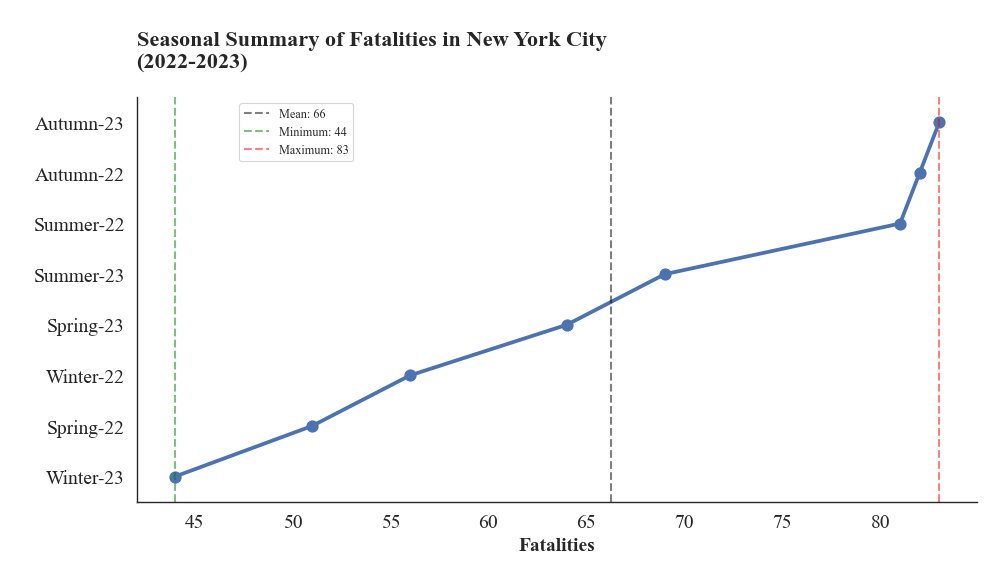

In [71]:
ax = (sns
      .catplot(data=seasonal_fatalities_summary, x='total', y='season', 
               kind='point', orient='h', height=5, aspect=2)
      .set_xlabels('Fatalities', fontweight='bold')
      .set_ylabels(' ')
      )
for ax in ax.axes.flat:
    ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.set_title('\nSeasonal Summary of Fatalities in New York City\n(2022-2023)\n',
                 fontweight='bold', loc='left')
    ax.axvline(x = seasonal_fatalities_summary.total.mean(), color = 'black', 
               linestyle='--', linewidth = 1.5, alpha = 0.5, 
               label = f'Mean: {seasonal_fatalities_summary.total.mean():,.0f}')
    ax.axvline(x = seasonal_fatalities_summary.total.min(), color = 'green', 
               linestyle='--', linewidth = 1.5, alpha = 0.5, 
               label = f'Minimum: {seasonal_fatalities_summary.total.min():,.0f}')
    ax.axvline(x = seasonal_fatalities_summary.total.max(), color = 'red', 
               linestyle='--', linewidth = 1.5, alpha = 0.5, 
               label = f'Maximum: {seasonal_fatalities_summary.total.max():,.0f}')
    plt.legend(bbox_to_anchor=(0.19, 1), loc='upper center', ncol=1)
    


>#### **Seasonal Fatalities**

- **Overall Average**: The average seasonal fatalities across both years stands at **66**.

- **Autumn 2023**: During the autumn of 2023, there was a spike in fatalities, with **83** incidents. This season proved to be particularly dangerous for road users.

- **Winter 2023**: Conversely, the winter of 2023 recorded the lowest number of fatalities incidents, with **44** lives lost.

In [72]:
## Pivoted fatalities summary ordered by seasons
seasonal_fatalities = (seasonal_fatalities_summary
                       .melt(id_vars=['season'],
                             value_vars=['pedestrians', 'cyclists', 'motorists'],
                             var_name='road_user_group',value_name='value'
                             )
                       .sort_values(by='season', ascending=True)
                       .assign(road_user_group = lambda x: x.road_user_group.str.title())
                       .pivot(columns='road_user_group', index='season', values='value')
                       )
seasonal_fatalities



road_user_group,Cyclists,Motorists,Pedestrians
season,,,
Autumn-22,4,26,52
Autumn-23,5,41,37
Spring-22,3,21,27
Spring-23,10,26,28
Summer-22,9,43,29
Summer-23,6,43,20
Winter-22,3,26,27
Winter-23,8,17,19


## **Injuries Analysis**

In [73]:
road_user_injuries_query = """
    SELECT
        vc_tbl.date AS date,
        i_tbl.pedestrians AS pedestrians,
        i_tbl.cyclists AS cyclists,
        i_tbl.motorists AS motorists
    FROM
        injuries AS i_tbl JOIN collisions AS vc_tbl USING(collision_id)
"""
road_user_injuries = (pd.read_sql_query(road_user_injuries_query, connection)
                      .assign(date = lambda x: pd.to_datetime(x.date))
                      )
road_user_injuries.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200467 entries, 0 to 200466
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         200467 non-null  datetime64[ns]
 1   pedestrians  200467 non-null  int64         
 2   cyclists     200467 non-null  int64         
 3   motorists    200467 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.1 MB


### **Annual Injuries Analysis**

In [74]:
daily_injuries_summary = (road_user_injuries
                            .set_index('date')
                            .resample('D').sum()
                            .assign(total= lambda x: x.pedestrians + x.cyclists + x.motorists)
                            .reset_index()
                            )
daily_injuries_summary.head()


,date,pedestrians,cyclists,motorists,total
0,2022-01-01,24,10,104,138
1,2022-01-02,12,8,53,73
2,2022-01-03,15,5,59,79
3,2022-01-04,27,2,83,112
4,2022-01-05,25,6,118,149


In [75]:
(daily_injuries_summary[['pedestrians','motorists','cyclists','total']]
 .describe().T
 .drop(columns = 'count')
 .astype(int)
 )


,mean,std,min,25%,50%,75%,max
pedestrians,24,9,4,19,24,29,83
motorists,100,20,48,87,100,114,165
cyclists,13,6,0,9,14,18,35
total,138,25,62,121,140,156,215


In [76]:
annual_injuries = (daily_injuries_summary
                     .set_index('date')
                      .resample('Y').sum()
                      .reset_index()
                      )
annual_injuries = (annual_injuries
                     .assign(year = lambda x: x.date.dt.year)
                     .rename(columns = {'pedestrians':'Pedestrians',
                                        'cyclists':'Cyclists',
                                        'motorists':'Motorists',
                                        'total':'Total',
                                        'year':'Year'}
                             )
                     )
annual_injuries


,date,Pedestrians,Cyclists,Motorists,Total,Year
0,2022-12-31,8973,5027,35540,49540,2022
1,2023-12-31,9078,5178,37574,51830,2023


In [77]:
annual_injuries = (annual_injuries
                     .melt(id_vars=['Year'],
                           value_vars=['Pedestrians', 'Cyclists', 'Motorists', 'Total'],
                           var_name='road_user_group',
                           value_name='value'
                           )
                     .pivot(index='road_user_group', columns='Year', values='value')
                     )


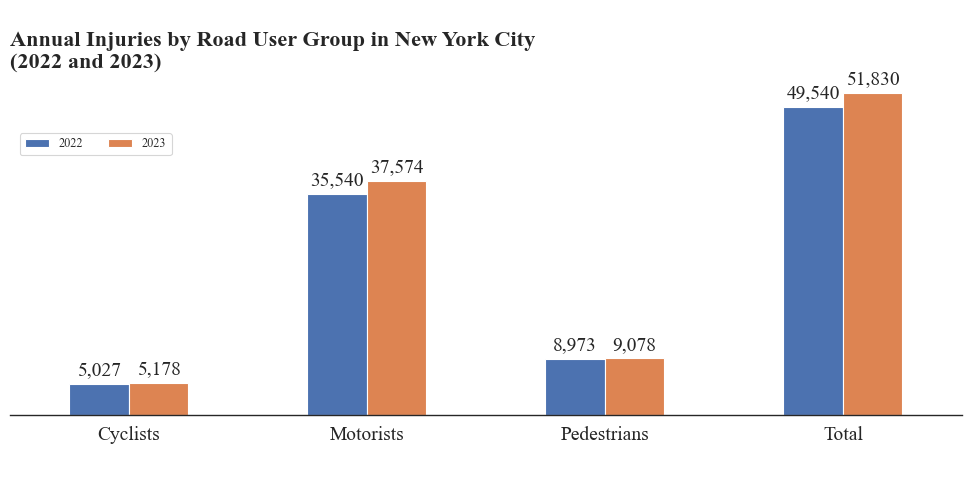

In [78]:
ax = annual_injuries.plot(kind='bar')
ax.set_xticklabels(annual_injuries.index, rotation=0, ha='center')
ax.set_xlabel(' ')
ax.set_title('\nAnnual Injuries by Road User Group in New York City\n(2022 and 2023)', loc='left', fontweight='bold')
ax.spines['left'].set_visible(False)
ax.tick_params(left=False, labelleft=False)
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
plt.legend(bbox_to_anchor=(0.09, 0.85),
           loc='upper center', ncol=2)
plt.tight_layout()
plt.show()


>#### **Annual Fatalities Story**

Between 2022 and 2023, the overall number of injured road users increased by **2%**. Here are the specifics:

- **Overall Trends**:
    - In 2022, there were **49,540** injuries.
    - In 2023, this number rose to **51,830** injuries.

- **Cyclists**:
    - Cyclists experienced a slight increase in injuries, rising by **1%**.
    - In 2022, there were **5,027** cyclist injuries.
    - In 2023, this number increased to **5,178**.

- **Motorists**:
    - Motor vehicle occupants (motorists) saw a more significant increase in injuries, rising by **3%**.
    - In 2022, there were **35,540** motorist injuries.
    - In 2023, this number rose to **37,574**.

- **Pedestrians**:
    - Pedestrians also experienced an increase in injuries.
    - In 2022, there were **8,973** pedestrian injuries.
    - In 2023, this number increased to **9,078**.


## **Collisions and Fatalities by Street Type**

In the context of motor vehicle collisions, `on street, off street, and cross street` refer to the locations where collisions occur. Here's how they can be differentiated:

  - **On Street:** Collisions that occur on the roadway itself. This includes incidents that happen within the flow of traffic on a particular street.
  - **Off Street:** Collisions that occur in areas not directly on the roadway, such as in parking lots, driveways, or other areas adjacent to the street.
  - **Cross Street:** Collisions that occur at or near intersections where two or more streets cross each other.

In [79]:
street_type_query = """
WITH street_class_tbl AS (
SELECT
    collision_id AS collision_id,
    Town AS town,
    zip_code AS zip_code,
    latitude AS latitude,
    longitude AS longitude,
    off_street_name AS off_street_name,
    on_street_name AS on_street_name,
    cross_street_name AS cross_street_name,
    CASE
        WHEN on_street_name IS NOT NULL AND cross_street_name IS NOT NULL THEN 'Intersection'
        WHEN on_street_name IS NOT NULL AND cross_street_name IS NULL THEN 'On Street'
        WHEN off_street_name IS NOT NULL THEN 'Off Street'
        ELSE 'Not Classified'
    END AS street_class
FROM collisions
),
total_fatalities AS (
    SELECT
        collision_id AS collision,
        (pedestrians + cyclists + motorists) AS total_fatalities
    FROM
        deaths
),
merged_tbl AS (
    SELECT
        sc_tbl.collision_id AS collision_id,
        sc_tbl.town AS town,
        sc_tbl.zip_code AS zip_code,
        sc_tbl.latitude AS latitude,
        sc_tbl.longitude AS longitude,
        sc_tbl.off_street_name AS off_street_name,
        sc_tbl.on_street_name AS on_street_name,
        sc_tbl.cross_street_name AS cross_street_name,
        sc_tbl.street_class AS street_class,
        tf_tbl.total_fatalities AS total_fatalities
    FROM
        street_class_tbl AS sc_tbl JOIN total_fatalities AS tf_tbl
                                   ON
                                   sc_tbl.collision_id = tf_tbl.collision
)
SELECT *
FROM merged_tbl;
"""
street_type = pd.read_sql_query(street_type_query,connection).assign(town = lambda x: x.town.str.title())
street_type.town.unique()


array([None, 'Bronx', 'Manhattan', 'Staten Island', 'Brooklyn', 'Queens'],
      dtype=object)

### **Collisions by Street Type Analysis**

In [80]:
collisions_by_street_type = (street_type
                             .groupby('street_class', as_index=False)
                             .size()
                             .sort_values(by='size', ascending=True)
                             .rename(columns = {'size':'collisions'})
                             .assign(pct_collisions = lambda x: round(x.collisions/x.collisions.sum()*100,0).astype(int))
                             .query("collisions > 5")
                             )
collisions_by_street_type


,street_class,collisions,pct_collisions
3,On Street,49814,25
2,Off Street,55045,27
0,Intersection,95605,48


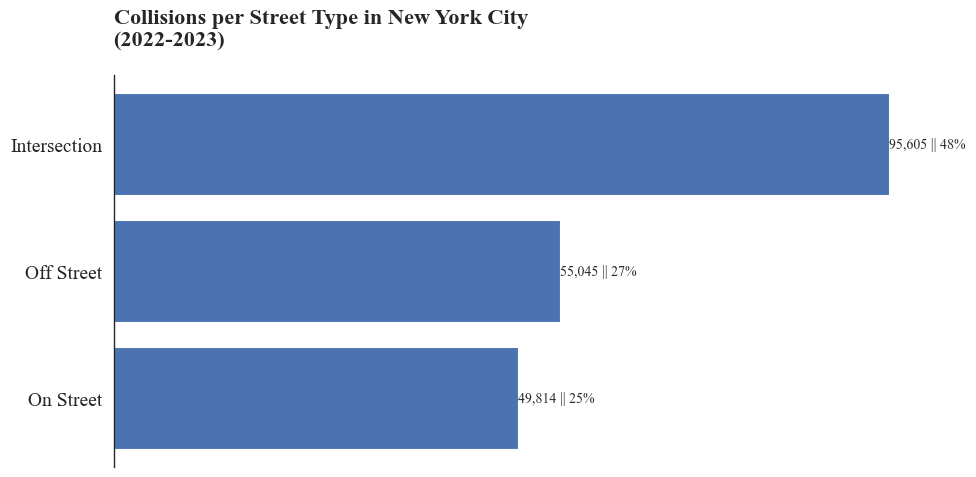

In [81]:
fig, ax = plt.subplots()
ax.barh(collisions_by_street_type['street_class'], collisions_by_street_type['collisions'])
ax.set_title('Collisions per Street Type in New York City\n(2022-2023)\n', loc='left', fontweight='bold')
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)

for i, (collision_count, pct_collision) in enumerate(zip(collisions_by_street_type['collisions'], collisions_by_street_type['pct_collisions'])):
  count = f"{collision_count:,.0f}"
  pct = f"{pct_collision:,.0f}%"
  
  ax.text(collision_count + 0.1, i, f"{count} || {pct}", va="center", fontsize=10)

plt.tight_layout();


### **Fatalities by Street Type Analysis**

In [82]:
fatalities_by_street_type = (street_type
                             .groupby('street_class', as_index=False).total_fatalities
                             .sum()
                             .sort_values(by='total_fatalities', ascending=True)
                             .assign(pct_fatalities = lambda x: round(x.total_fatalities/x.total_fatalities.sum()*100,0).astype(int))
                             .query("total_fatalities > 5")
                             )
fatalities_by_street_type


,street_class,total_fatalities,pct_fatalities
2,Off Street,19,4
3,On Street,201,38
0,Intersection,310,58


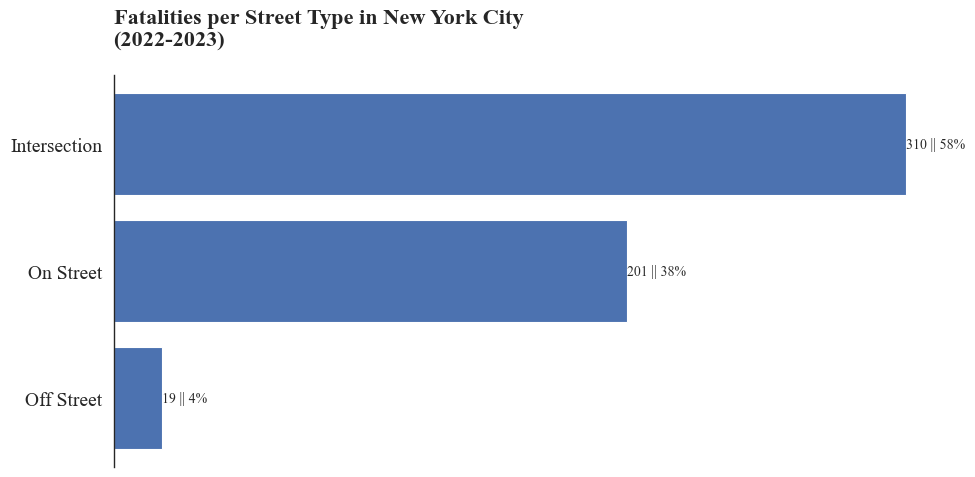

In [83]:
fig, ax = plt.subplots()
ax.barh(fatalities_by_street_type['street_class'], fatalities_by_street_type['total_fatalities'])
ax.set_title('Fatalities per Street Type in New York City\n(2022-2023)\n', loc='left', fontweight='bold')
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)

for i, (fatalities_count, pct_fatalities) in enumerate(zip(fatalities_by_street_type['total_fatalities'], fatalities_by_street_type['pct_fatalities'])):
  count = f"{fatalities_count:,.0f}"
  pct = f"{pct_fatalities:,.0f}%"
  
  ax.text(fatalities_count + 0.1, i, f"{count} || {pct}", va="center", fontsize=10)

plt.tight_layout();


In [84]:
location_collisions = (street_type
                       .groupby(['town','zip_code'], as_index=False)
                       .size()
                       .sort_values(by='size',ascending=False)
                       )
location_collisions 


,town,zip_code,size
30,Brooklyn,11207,3356
31,Brooklyn,11208,2210
58,Brooklyn,11236,2210
35,Brooklyn,11212,2119
26,Brooklyn,11203,1948
...,...,...,...
114,Manhattan,10106,1
115,Manhattan,10110,1
116,Manhattan,10111,1
123,Manhattan,10122,1


In [85]:
fatalities_by_location = (street_type
                             .groupby(['town','zip_code'], as_index=False).total_fatalities
                             .sum()
                             .sort_values(by='total_fatalities', ascending=False)
                             )
fatalities_by_location


,town,zip_code,total_fatalities
16,Bronx,10467,6
58,Brooklyn,11236,6
52,Brooklyn,11230,6
60,Brooklyn,11238,5
41,Brooklyn,11218,5
...,...,...,...
122,Manhattan,10121,0
121,Manhattan,10120,0
120,Manhattan,10119,0
119,Manhattan,10118,0


In [86]:
merged_col_fatal_by_loc = (pd.merge(left=fatalities_by_location,
                                    right=location_collisions,
                                    how='inner',
                                    on='zip_code')
                           .drop(columns='town_y')
                           .rename(columns={'town_x':'borough',
                                            'size':'collisions'})
                           .assign(zip_code = lambda x:x.zip_code.astype(int))
                           )
merged_col_fatal_by_loc


,borough,zip_code,total_fatalities,collisions
0,Bronx,10467,6,1342
1,Brooklyn,11236,6,2210
2,Brooklyn,11230,6,1135
3,Brooklyn,11238,5,773
4,Brooklyn,11218,5,1089
...,...,...,...,...
226,Manhattan,10121,0,3
227,Manhattan,10120,0,4
228,Manhattan,10119,0,11
229,Manhattan,10118,0,3


In [87]:
merged_col_fatal_by_loc.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   borough           231 non-null    object
 1   zip_code          231 non-null    int32 
 2   total_fatalities  231 non-null    int64 
 3   collisions        231 non-null    int64 
dtypes: int32(1), int64(2), object(1)
memory usage: 6.4+ KB


In [88]:
zip_codes = pd.read_csv(r'simplemaps_uszips_basicv1.85\uszips.csv').rename(columns={'zip':'zip_code'}).assign(zip_code = lambda x: x.zip_code.astype(int))
zip_codes


,zip_code,lat,lng,city,state_id,state_name,zcta,parent_zcta,population,density,county_fips,county_name,county_weights,county_names_all,county_fips_all,imprecise,military,timezone
0,601,18.18,-66.75,Adjuntas,PR,Puerto Rico,True,NaN,"16,834.00",100.90,72001,Adjuntas,"{""72001"": 98.74, ""72141"": 1.26}",Adjuntas|Utuado,72001|72141,False,False,America/Puerto_Rico
1,602,18.36,-67.18,Aguada,PR,Puerto Rico,True,NaN,"37,642.00",479.20,72003,Aguada,"{""72003"": 100}",Aguada,72003,False,False,America/Puerto_Rico
2,603,18.46,-67.12,Aguadilla,PR,Puerto Rico,True,NaN,"49,075.00",551.70,72005,Aguadilla,"{""72005"": 99.76, ""72099"": 0.24}",Aguadilla|Moca,72005|72099,False,False,America/Puerto_Rico
3,606,18.17,-66.94,Maricao,PR,Puerto Rico,True,NaN,"5,590.00",48.70,72093,Maricao,"{""72093"": 82.27, ""72153"": 11.66, ""72121"": 6.06}",Maricao|Yauco|Sabana Grande,72093|72153|72121,False,False,America/Puerto_Rico
4,610,18.29,-67.12,Anasco,PR,Puerto Rico,True,NaN,"25,542.00",265.70,72011,Añasco,"{""72011"": 96.71, ""72099"": 2.82, ""72083"": 0.37,...",Añasco|Moca|Las Marías|Aguada,72011|72099|72083|72003,False,False,America/Puerto_Rico
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33782,99923,55.98,-130.04,Hyder,AK,Alaska,True,NaN,25.00,0.60,2198,Prince of Wales-Hyder,"{""02198"": 100}",Prince of Wales-Hyder,02198,False,False,America/Sitka
33783,99925,55.55,-132.96,Klawock,AK,Alaska,True,NaN,920.00,6.60,2198,Prince of Wales-Hyder,"{""02198"": 100}",Prince of Wales-Hyder,02198,False,False,America/Sitka
33784,99926,55.13,-131.49,Metlakatla,AK,Alaska,True,NaN,"1,465.00",4.30,2198,Prince of Wales-Hyder,"{""02198"": 100}",Prince of Wales-Hyder,02198,False,False,America/Metlakatla
33785,99927,56.33,-133.60,Point Baker,AK,Alaska,True,NaN,14.00,1.20,2198,Prince of Wales-Hyder,"{""02198"": 100}",Prince of Wales-Hyder,02198,False,False,America/Sitka


In [89]:
merged_loc_data = (pd.merge(zip_codes, merged_col_fatal_by_loc,
                           on='zip_code', how='inner')
                   [['zip_code','lat','lng','borough','total_fatalities','collisions']]
                   .sort_values(by='collisions',ascending=False)
                   .rename(columns = {'lng':'long'})
                   )
merged_loc_data


,zip_code,lat,long,borough,total_fatalities,collisions
114,11207,40.67,-73.89,Brooklyn,3,3356
115,11208,40.67,-73.87,Brooklyn,1,2210
145,11236,40.64,-73.90,Brooklyn,6,2210
117,11208,40.67,-73.87,Queens,0,2210
122,11212,40.66,-73.91,Brooklyn,1,2119
...,...,...,...,...,...,...
50,10162,40.77,-73.95,Manhattan,0,1
170,11371,40.77,-73.87,Queens,0,1
43,10111,40.76,-73.98,Manhattan,0,1
42,10110,40.75,-73.98,Manhattan,0,1


In [90]:
grouped = (merged_loc_data
           .groupby('borough', as_index=False)
           [['total_fatalities','collisions']]
           .sum()
           .assign(pct_fatalities = lambda x: x.total_fatalities/x.total_fatalities.sum()*100,
                   pct_collisions = lambda x: x.collisions/x.collisions.sum()*100)
           )
grouped


,borough,total_fatalities,collisions,pct_fatalities,pct_collisions
0,Bronx,53,22785,19.27,16.30
1,Brooklyn,88,48625,32.00,34.78
2,Manhattan,49,23702,17.82,16.95
3,Queens,72,39247,26.18,28.07
4,Staten Island,13,5441,4.73,3.89


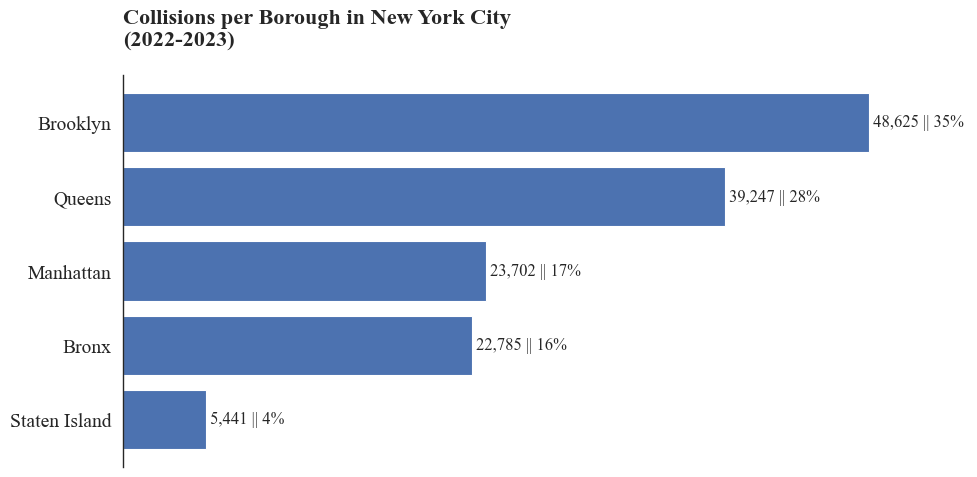

In [91]:
fig, ax = plt.subplots()
grouped = grouped.sort_values(by='collisions', ascending=True)
ax.barh(grouped['borough'], grouped['collisions'])
ax.set_title('Collisions per Borough in New York City\n(2022-2023)\n', loc='left', fontweight='bold')
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)

for i, (collision_count, pct_collision) in enumerate(zip(grouped['collisions'], grouped['pct_collisions'])):
  count = f"{collision_count:,.0f}"
  pct = f"{pct_collision:,.0f}%"
  
  ax.text(collision_count + 0.1, i, f" {count} || {pct} ", va="center", fontsize=12)

plt.tight_layout();


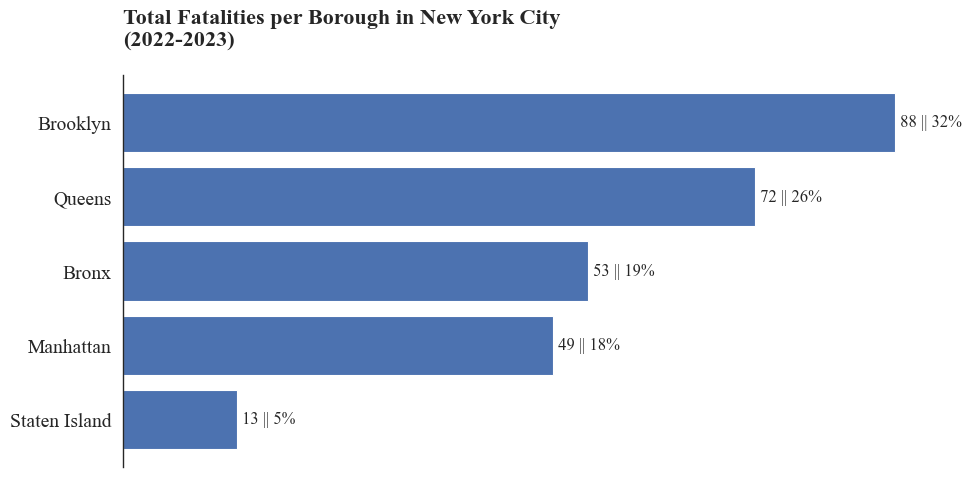

In [92]:
fig, ax = plt.subplots()
grouped = grouped.sort_values(by='total_fatalities', ascending=True)
ax.barh(grouped['borough'], grouped['total_fatalities'])
ax.set_title('Total Fatalities per Borough in New York City\n(2022-2023)\n', loc='left', fontweight='bold')
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)

for i, (collision_count, pct_collision) in enumerate(zip(grouped['total_fatalities'], grouped['pct_fatalities'])):
  count = f"{collision_count:,.0f}"
  pct = f"{pct_collision:,.0f}%"
  
  ax.text(collision_count + 0.1, i, f" {count} || {pct} ", va="center", fontsize=12)

plt.tight_layout();


## **Contributing Factors of Collisions per Vehicle**

In [93]:
## Generate a summary table of the unique vehicle types
vehicle_types_query = """ 
    WITH vehicle_1_cf AS (
        SELECT
            vehicle_1 AS contributing_factor,
            COUNT(*) AS vehicles
        FROM
            causes
        WHERE
            vehicle_1 != 'None'
        GROUP BY
            contributing_factor
    ),
    vehicle_2_cf AS (
        SELECT 
            vehicle_2 AS contributing_factor,
            COUNT(*) AS vehicles
        FROM
            causes
        WHERE
            vehicle_2 != 'None'
        GROUP BY
            contributing_factor
    ),
    vehicle_3_cf AS (
        SELECT
            vehicle_3 AS contributing_factor,
            COUNT(*) AS vehicles
        FROM
            causes
        WHERE
            vehicle_3 != 'None'
        GROUP BY
            contributing_factor
    ),
    vehicle_4_cf AS (
        SELECT
            vehicle_4 AS contributing_factor,
            COUNT(*) AS vehicles
        FROM
            causes
        WHERE 
            vehicle_4 != 'None'
        GROUP BY
            contributing_factor
    ),
    vehicle_5_cf AS (
        SELECT 
            vehicle_5 AS contributing_factor,
            COUNT(*) AS vehicles
        FROM
            causes
        WHERE
            vehicle_5 != 'None'
        GROUP BY
            contributing_factor
    ), 
    merged_types AS (
        SELECT
             v_1_t_tbl.contributing_factor,
             v_1_t_tbl.vehicles
        FROM
            vehicle_1_cf AS v_1_t_tbl
        UNION
        SELECT
             v_2_t_tbl.contributing_factor,
             v_2_t_tbl.vehicles
        FROM
            vehicle_2_cf AS v_2_t_tbl
        UNION
        SELECT
             v_3_t_tbl.contributing_factor,
             v_3_t_tbl.vehicles
        FROM
            vehicle_3_cf AS v_3_t_tbl
        UNION
        SELECT
             v_4_t_tbl.contributing_factor,
             v_4_t_tbl.vehicles
        FROM
            vehicle_4_cf AS v_4_t_tbl
        UNION
        SELECT
             v_5_t_tbl.contributing_factor,
             v_5_t_tbl.vehicles
        FROM
            vehicle_5_cf AS v_5_t_tbl
    )
    SELECT 
        contributing_factor,
        SUM(vehicles) AS vehicles
    FROM 
        merged_types
    GROUP BY
        contributing_factor
    ORDER BY
        vehicles ASC;
"""

vehicle_types = pd.read_sql_query(vehicle_types_query, connection).drop_duplicates('contributing_factor')
vehicle_types = vehicle_types[vehicle_types['contributing_factor'] != 'Unspecified']
vehicle_types = (vehicle_types
                 .assign(pct_vehicles = lambda x: x.vehicles/x.vehicles.sum()*100)
                 .nlargest(10, 'vehicles')
                 )
vehicle_types


,contributing_factor,vehicles,pct_vehicles
53,Driver Inattention/Distraction,59079,33.47
52,Following Too Closely,15581,8.83
51,Failure to Yield Right-of-Way,15358,8.70
50,Passing or Lane Usage Improper,10560,5.98
49,Unsafe Speed,8596,4.87
48,Other Vehicular,8236,4.67
47,Passing Too Closely,8095,4.59
46,Traffic Control Disregarded,6834,3.87
45,Backing Unsafely,6417,3.64
44,Turning Improperly,5121,2.90


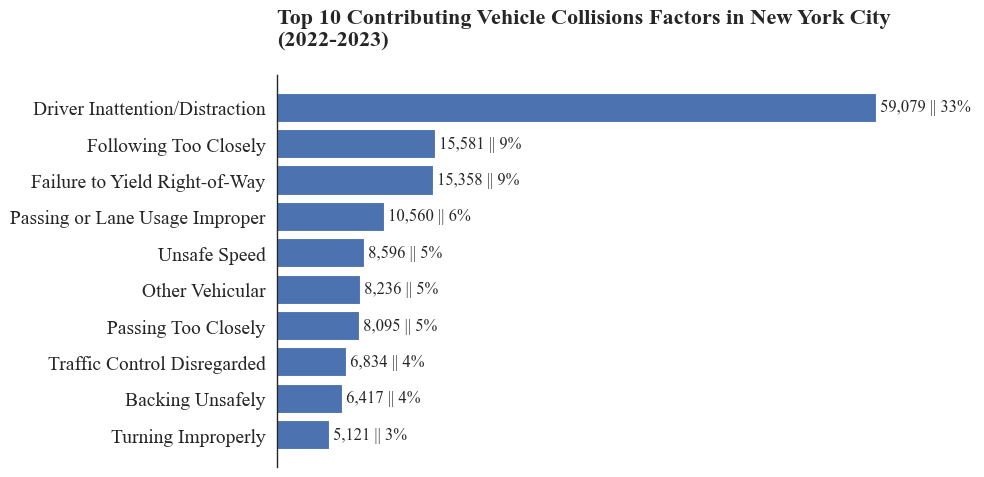

In [94]:
fig, ax = plt.subplots()
vehicle_types = vehicle_types.sort_values(by='vehicles', ascending=True)
ax.barh(vehicle_types['contributing_factor'], vehicle_types['vehicles'])
ax.set_title('Top 10 Contributing Vehicle Collisions Factors in New York City\n(2022-2023)\n', loc='left', fontweight='bold')
ax.spines['bottom'].set_visible(False)
ax.tick_params(bottom=False, labelbottom=False)

for i, (collision_count, pct_collision) in enumerate(zip(vehicle_types['vehicles'], vehicle_types['pct_vehicles'])):
  count = f"{collision_count:,.0f}"
  pct = f"{pct_collision:,.0f}%"
  
  ax.text(collision_count + 0.1, i, f" {count} || {pct} ", va="center", fontsize=12)

plt.tight_layout();
